# Here preprocessing (log-transform, median correction) is done

NOTE: Minmax scaling (as this integrates feature information of all samples) must only be fitted on the training set

In [2]:
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from matplotlib_venn import venn2


sys.path.append("../")
import AtlasAnalysisFunctions as AAF
import utils_ML as uml

In [16]:
nsaf = pd.read_hdf("../../Atlas_creation/proteome_nsaf_pooled_3.h5")
nsaf = nsaf.pivot(index = "assay_id", columns = "uniprot_id", values = "NSAF")

meta = pd.read_csv("../../Metadata/unified_metadata.csv", index_col="assay_id")

# Drop low identification rate samples (see Abundance_correction.ipynb for reasoning)
low_id_rate = nsaf.loc[meta[meta.PXD_accession.isin("PXD002842 PXD003407 PXD003406 PXD002057 PXD009149 PXD005045 PXD009442 PXD003530 PXD004452".split())].index,:].notna().sum(axis=1)
drop_assays = low_id_rate.index[low_id_rate < 1100]
nsaf = nsaf.loc[~nsaf.index.isin(drop_assays)]

meta = meta[meta.index.isin(nsaf.index)]
groups = pd.read_csv("../../Metadata/group_cells_annotation.csv", sep =";", index_col="Unnamed: 0")
meta["Group"] = meta.cell_line.apply(lambda x: groups[groups.cell_line == x]["group"].values[0])

# Only select groups with >= 10 samples
apc = meta.Group.value_counts(sort = True)
apc=apc[apc>=10]

meta = meta[meta.Group.isin(apc.index)]
nsaf = nsaf[nsaf.index.isin(meta.index)]

print(meta.shape, nsaf.shape)

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


(518, 20) (518, 14507)


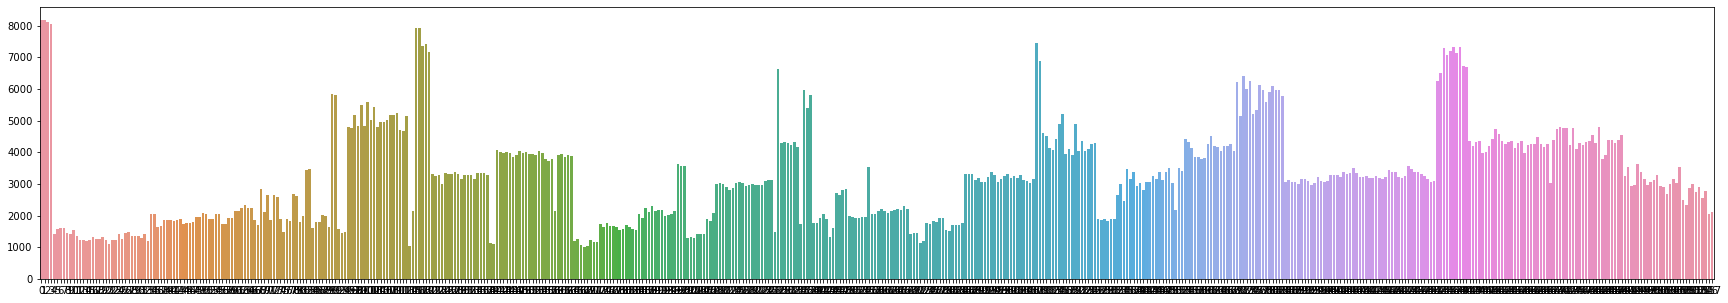

In [18]:
# Protein identification landscape
plt.figure(figsize=(30,5))
sns.barplot(x=list(range(len(nsaf))), y=nsaf.notna().sum(axis=1))

1618


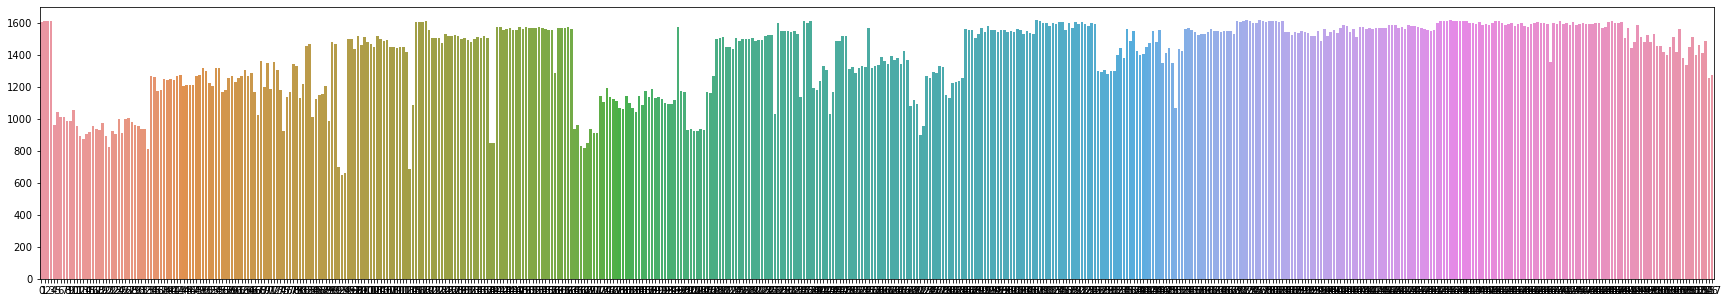

In [22]:
reoccuring, deleted = AAF._identify_global_reoccured_proteins(nsaf.fillna(0), .7)
nsaf_reoccur = nsaf.loc[:,reoccuring]
print(len(reoccuring))

plt.figure(figsize=(30,5))
sns.barplot(x=list(range(len(nsaf_reoccur))), y=nsaf_reoccur.notna().sum(axis=1))

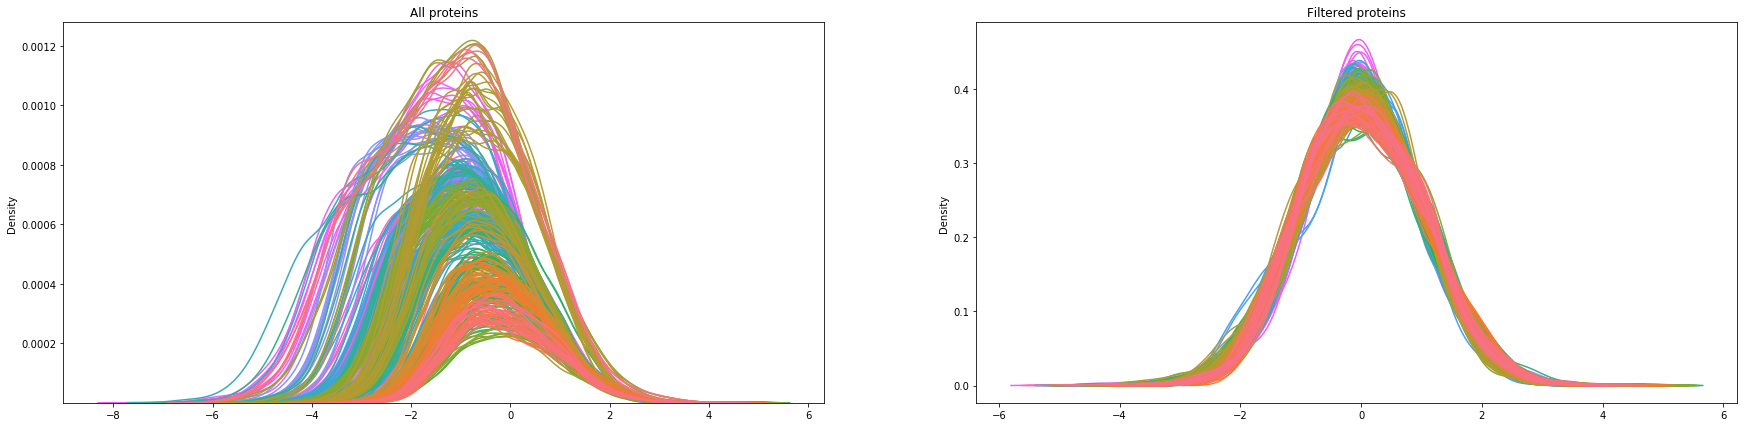

In [23]:
def calc_median(row):
    values = row[row!=0]
    return np.median(values)

# Log2 normalize
log_nsaf = np.log2(nsaf)

# Find reoccuring prots
reoccuring, deleted = AAF._identify_global_reoccured_proteins(nsaf.fillna(0), .7)
log_nsaf_reoccur = log_nsaf.loc[:,reoccuring]

# Define median and std
med_std = pd.DataFrame()
med_std['median'] = log_nsaf_reoccur.fillna(0).apply(lambda x: calc_median(x), axis =1)
med_std['std'] = log_nsaf_reoccur.apply(lambda x: np.std(x), axis =1)

# Scale samples
def scale_sample(row):
    median, std = med_std.loc[row.name,:]
    return (row-median)/std

scaled_nsaf = log_nsaf.apply(lambda x: scale_sample(x), axis = 1)
scaled_nsaf_reoccur = scaled_nsaf.loc[:,reoccuring]

# Plotting the abundance values of the full and the filtered dataset
fig, ax = plt.subplots(1,2,figsize=(30,7))

ax[0].set_title('All proteins')
sns.kdeplot(data=scaled_nsaf.transpose(), legend = False, ax =ax[0])

ax[1].set_title("Filtered proteins")
sns.kdeplot(data=scaled_nsaf_reoccur.transpose(), legend = False, common_norm=False, ax =ax[1])

In [25]:
scaled_nsaf.to_csv("../PEMatrix/norm_NSAF_data2.csv")

In [3]:
data = pd.read_csv("../PEMatrix/norm_NSAF_data2.csv", index_col = "assay_id")
meta = pd.read_csv("../../Metadata/unified_metadata.csv")
meta = meta[meta.assay_id.isin(data.index)]

groups = pd.read_csv("../../Metadata/group_cells_annotation.csv", sep =";", index_col="Unnamed: 0")
meta["Group"] = meta.cell_line.apply(lambda x: groups[groups.cell_line == x]["group"].values[0])
meta = meta.set_index("assay_id")

data.sort_index(inplace=True)
meta.sort_index(inplace=True)

In [5]:
from combat.pycombat import pycombat

In [17]:
data.T.melt().assay_id.unique()[:20]

array([30960, 30961, 31008, 31009, 31102, 31103, 31104, 31105, 31138,
       31139, 31140, 31141, 31142, 31143, 31144, 31145, 31146, 31147,
       31148, 31149])

In [ ]:
data.T.melt().assay_id.unique()[:20]

In [22]:
meta.PXD_accession

assay_id
30960    PXD000533
30961    PXD000533
31008    PXD000533
31009    PXD000533
31488    PXD000529
           ...    
36299    PXD005354
36344    PXD005354
36347    PXD005354
36350    PXD005354
36416    PXD005354
Name: PXD_accession, Length: 518, dtype: object

In [28]:
meta.PXD_accession[:50].unique()

array(['PXD000533', 'PXD000529', 'PXD000443', 'PXD000426', 'PXD002842',
       'PXD008719', 'PXD001352', 'PXD007543'], dtype=object)

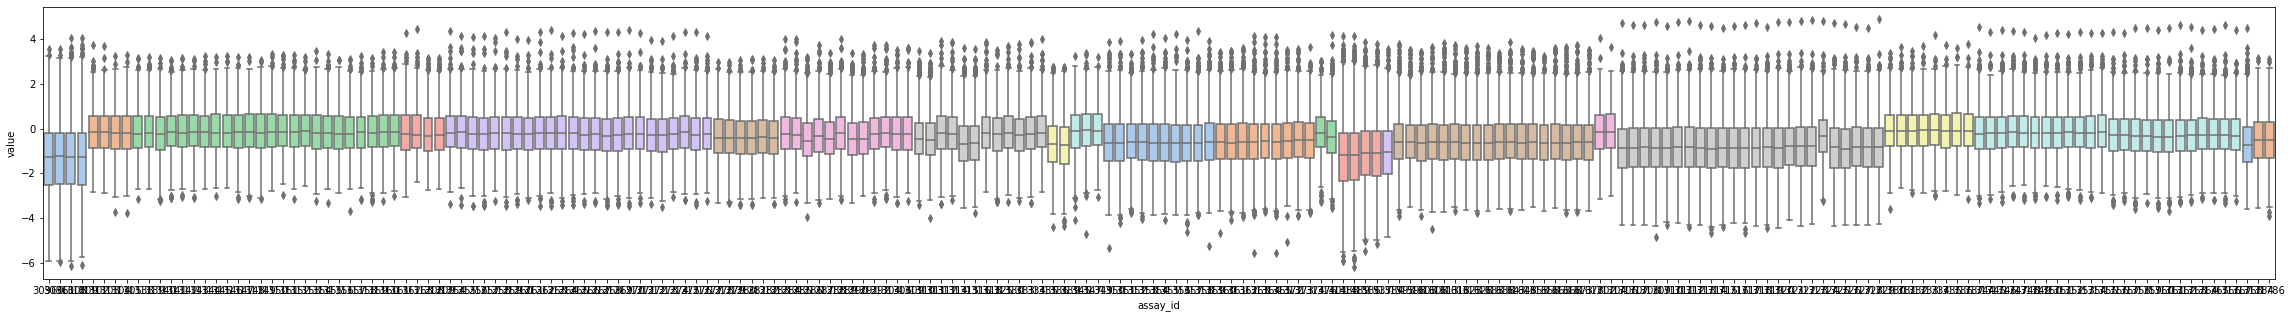

In [4]:
mapper = zip(meta.PXD_accession[:200].unique(), sns.color_palette("pastel", n_colors=meta.PXD_accession[:200].nunique()))
mapper = dict(mapper)
plt.figure(figsize=(40,5))
sns.boxplot(data=data.T.melt()[data.T.melt().assay_id.isin(data.T.melt().assay_id.unique()[:200])], y="value", x = "assay_id", palette=meta.iloc[:200,:].PXD_accession.apply(lambda x: mapper[x]).values)

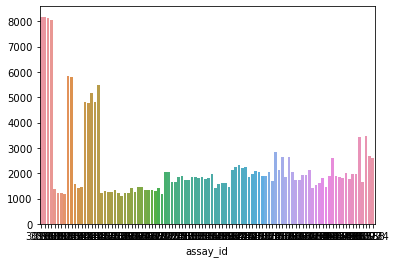

In [76]:
sns.barplot(y=data.notna().sum(axis=1)[:100],x=meta.index[:100])

In [16]:
preprocessor = uml.FilterByOccurence()
preprocessor2 = uml.LowestValueImputer()
prep_data = preprocessor.fit_transform(data)
prep_data = preprocessor2.fit_transform(prep_data)

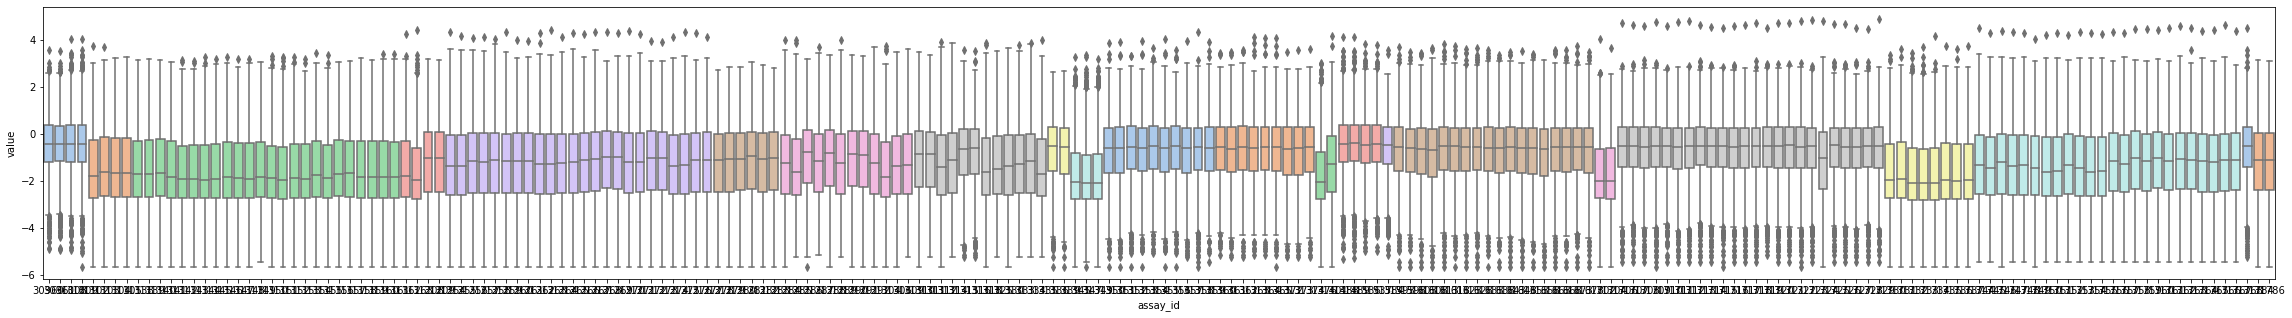

In [17]:
mapper = zip(meta.PXD_accession[:200].unique(), sns.color_palette("pastel", n_colors=meta.PXD_accession[:200].nunique()))
mapper = dict(mapper)
plt.figure(figsize=(40,5))
sns.boxplot(data=prep_data.T.melt()[prep_data.T.melt().assay_id.isin(prep_data.T.melt().assay_id.unique()[:200])], y="value", x = "assay_id", palette=meta.iloc[:200,:].PXD_accession.apply(lambda x: mapper[x]).values)

In [18]:
from sklearn.decomposition import PCA
embeddings = PCA(n_components=2).fit_transform(prep_data)

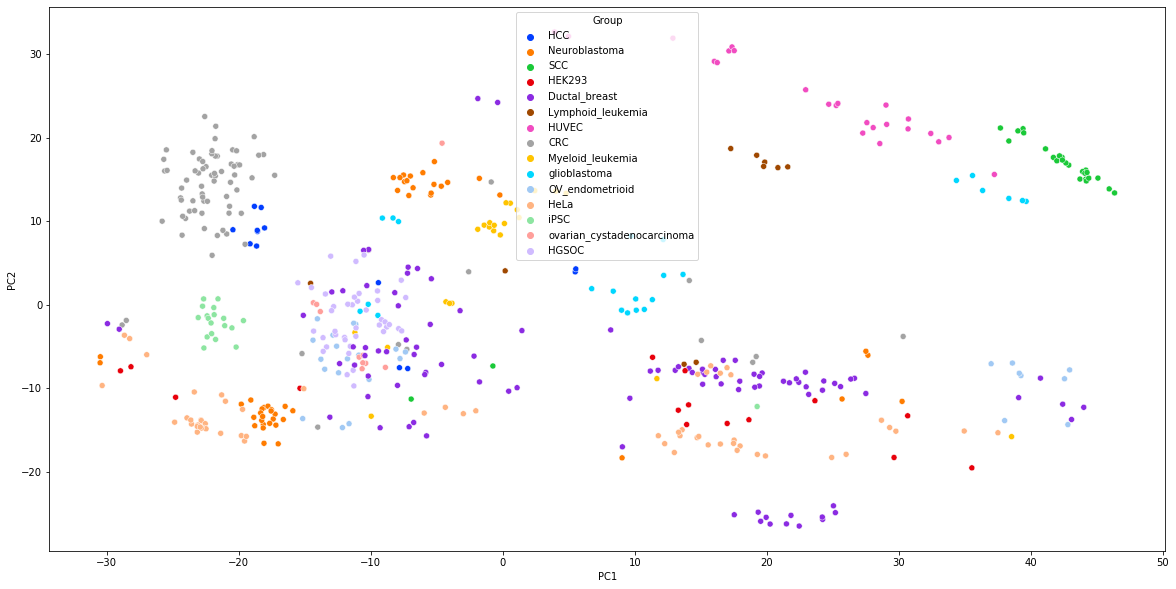

In [42]:
colors = sns.color_palette("bright") + sns.color_palette("pastel")
plt.figure(figsize=(20,10))
sns.scatterplot(data=pd.DataFrame(embeddings, columns=["PC1", "PC2"]), x= "PC1", y="PC2", hue = meta.Group.reset_index()["Group"], palette = colors[:15])

In [12]:
batches = meta.PXD_accession.tolist()

In [43]:
df_corrected_combat = pycombat(prep_data.T.fillna(0), batches)

Found 43 batches.

One batch has only one sample, try setting mean_only=True.

Adjusting for 0 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.


/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/combat/pycombat.py:91: RuntimeWarning: invalid value encountered in double_scalars
  return (2*s2+m*m)/s2
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/combat/pycombat.py:93: RuntimeWarning: invalid value encountered in double_scalars
  return (m*s2+m*m*m)/s2
/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/combat/pycombat.py:159: RuntimeWarning: divide by zero encountered in true_divide
  np.absolute(d_new-d_old)/d_old))  # maximum difference between new and old estimate


Adjusting the Data


In [ ]:
[31584, 31768, 31891, 31955, 32416]

In [63]:
df_corrected_combat.T.loc[~prep_data.index.isin([31584, 31768, 31891, 31955, 32416])]

,A0AVT1,A0MZ66,A0PJW6,A1X283,A2RRP1,A3KMH1,A3KN83,A4D1E9,A5YKK6,A6NDG6,...,Q9Y6J9,Q9Y6M5,Q9Y6N5,Q9Y6Q9,Q9Y6V7,Q9Y6W3,Q9Y6W5,Q9Y6X9,Q9Y6Y0,Q9Y6Y8
assay_id,,,,,,,,,,,,,,,,,,,,,
30960,0.386686,-0.138304,-1.971517,-2.139535,-2.071382,-1.212864,-1.885893,-1.471310,-0.847847,0.191181,...,-2.086855,-1.444373,-1.715364,-3.360878,-1.670694,-1.332449,-0.798253,-1.423925,-1.128652,-0.424790
30961,0.291196,-0.172355,-1.611192,-1.900154,-2.218610,-1.177423,-1.804030,-1.479296,-0.904131,0.229085,...,-2.314726,-1.250798,-1.684519,-2.965376,-1.087144,-1.237738,-0.788900,-1.331194,-1.613181,-0.537129
31008,-0.230499,-0.396256,-1.998437,-1.937674,-3.339236,-2.243617,-1.539775,-1.634459,-0.785504,-0.082091,...,-2.748387,-0.868371,-1.412875,-1.998794,-1.273978,-2.689203,-0.671531,-2.189619,-1.706836,-0.384577
31009,-0.141998,-0.524488,-2.009673,-1.949344,-2.876446,-2.259787,-1.364131,-1.514337,-0.860538,-0.214399,...,-2.125703,-0.879429,-1.381640,-2.176654,-1.167865,-2.705092,-0.584679,-1.674354,-2.278967,-0.535376
31102,0.010945,-0.486840,-1.715947,-1.888874,-2.704081,-1.561842,-1.737165,-1.760537,-0.748444,-0.043352,...,-2.337855,-0.733582,-2.008536,-2.651903,-1.401617,-2.030941,-0.725179,-1.738985,-1.724779,-0.423197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36558,-0.117914,-0.141878,-1.914788,-2.959186,-3.032466,-1.565505,-1.345947,-2.198861,-1.021331,0.470027,...,-2.734223,-0.380099,-1.413682,-3.431449,-0.710517,-1.639397,-0.555460,-1.406817,-0.426358,-1.118010
36563,-0.220342,0.254976,-1.914788,-1.203175,-3.032466,-2.535797,-1.727831,-2.198861,-0.892098,-0.585182,...,-2.734223,-0.225085,-0.939260,-2.532666,-1.765120,-3.192920,-0.687286,-1.201985,-1.936368,0.099372
36568,-0.581014,-0.500431,-1.914788,-1.218315,-3.032466,-2.535797,-1.752352,-2.198861,-0.935368,0.625834,...,-2.734223,-0.652784,-0.883611,-2.536707,-0.898313,-3.192920,-0.144255,-2.327282,-1.575519,-0.426160


In [66]:
from sklearn.manifold import TSNE

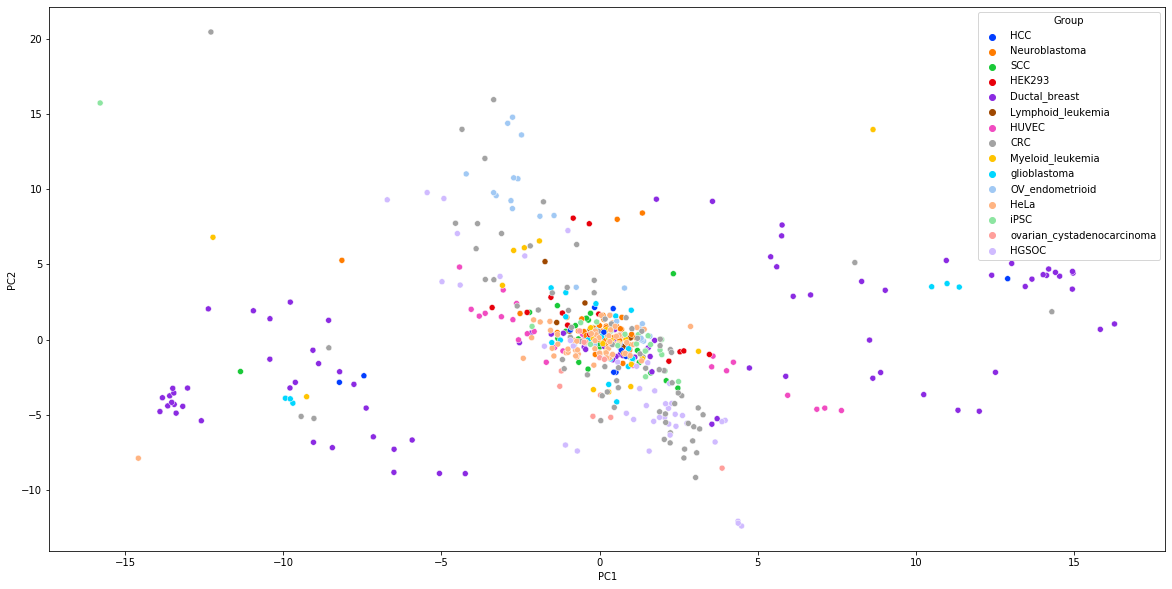

In [77]:
embeddings = PCA(n_components=2).fit_transform(df_corrected_combat.T.loc[~prep_data.index.isin([31584, 31768, 31891, 31955, 32416])])
colors = sns.color_palette("bright") + sns.color_palette("pastel")
plt.figure(figsize=(20,10))
sns.scatterplot(data=pd.DataFrame(embeddings, columns=["PC1", "PC2"]), x= "PC1", y="PC2", hue = meta[~meta.index.isin([31584, 31768, 31891, 31955, 32416])].Group.reset_index()["Group"], palette = colors[:15])

In [93]:
import numpy as np

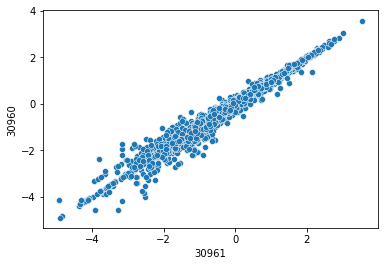

In [111]:
sns.scatterplot(data=prep_data.iloc[[0,1],:].T, x= 30961, y = 30960)

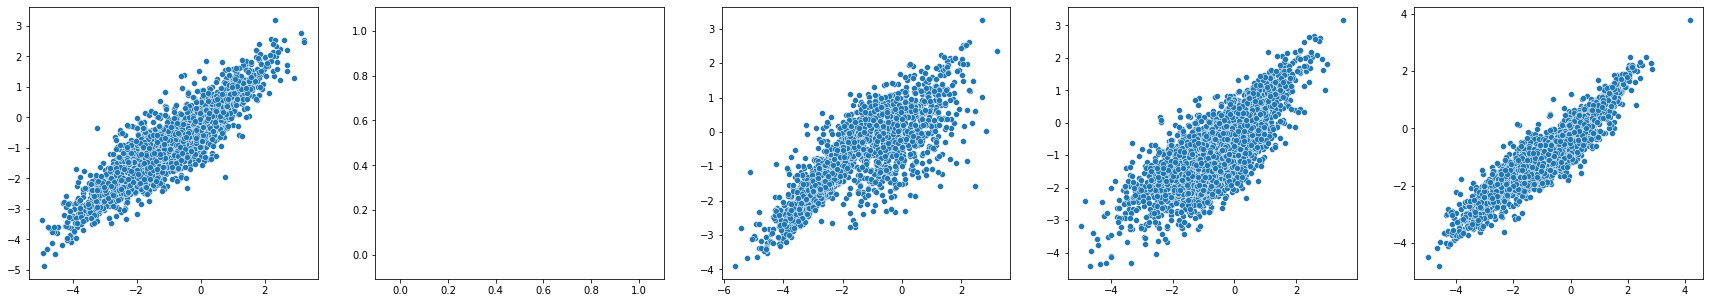

In [99]:
fig, ax = plt.subplots(1,5, figsize=(30,5))
for i,x in enumerate(np.random.randint(0,500,5)):
    sns.scatterplot(x=prep_data.iloc[x,:].tolist(), y =df_corrected_combat.iloc[:,x].tolist(), ax=ax[i])

In [45]:
df_corrected_combat.T

,A0AVT1,A0MZ66,A0PJW6,A1X283,A2RRP1,A3KMH1,A3KN83,A4D1E9,A5YKK6,A6NDG6,...,Q9Y6J9,Q9Y6M5,Q9Y6N5,Q9Y6Q9,Q9Y6V7,Q9Y6W3,Q9Y6W5,Q9Y6X9,Q9Y6Y0,Q9Y6Y8
assay_id,,,,,,,,,,,,,,,,,,,,,
30960,0.386686,-0.138304,-1.971517,-2.139535,-2.071382,-1.212864,-1.885893,-1.471310,-0.847847,0.191181,...,-2.086855,-1.444373,-1.715364,-3.360878,-1.670694,-1.332449,-0.798253,-1.423925,-1.128652,-0.424790
30961,0.291196,-0.172355,-1.611192,-1.900154,-2.218610,-1.177423,-1.804030,-1.479296,-0.904131,0.229085,...,-2.314726,-1.250798,-1.684519,-2.965376,-1.087144,-1.237738,-0.788900,-1.331194,-1.613181,-0.537129
31008,-0.230499,-0.396256,-1.998437,-1.937674,-3.339236,-2.243617,-1.539775,-1.634459,-0.785504,-0.082091,...,-2.748387,-0.868371,-1.412875,-1.998794,-1.273978,-2.689203,-0.671531,-2.189619,-1.706836,-0.384577
31009,-0.141998,-0.524488,-2.009673,-1.949344,-2.876446,-2.259787,-1.364131,-1.514337,-0.860538,-0.214399,...,-2.125703,-0.879429,-1.381640,-2.176654,-1.167865,-2.705092,-0.584679,-1.674354,-2.278967,-0.535376
31102,0.010945,-0.486840,-1.715947,-1.888874,-2.704081,-1.561842,-1.737165,-1.760537,-0.748444,-0.043352,...,-2.337855,-0.733582,-2.008536,-2.651903,-1.401617,-2.030941,-0.725179,-1.738985,-1.724779,-0.423197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36558,-0.117914,-0.141878,-1.914788,-2.959186,-3.032466,-1.565505,-1.345947,-2.198861,-1.021331,0.470027,...,-2.734223,-0.380099,-1.413682,-3.431449,-0.710517,-1.639397,-0.555460,-1.406817,-0.426358,-1.118010
36563,-0.220342,0.254976,-1.914788,-1.203175,-3.032466,-2.535797,-1.727831,-2.198861,-0.892098,-0.585182,...,-2.734223,-0.225085,-0.939260,-2.532666,-1.765120,-3.192920,-0.687286,-1.201985,-1.936368,0.099372
36568,-0.581014,-0.500431,-1.914788,-1.218315,-3.032466,-2.535797,-1.752352,-2.198861,-0.935368,0.625834,...,-2.734223,-0.652784,-0.883611,-2.536707,-0.898313,-3.192920,-0.144255,-2.327282,-1.575519,-0.426160


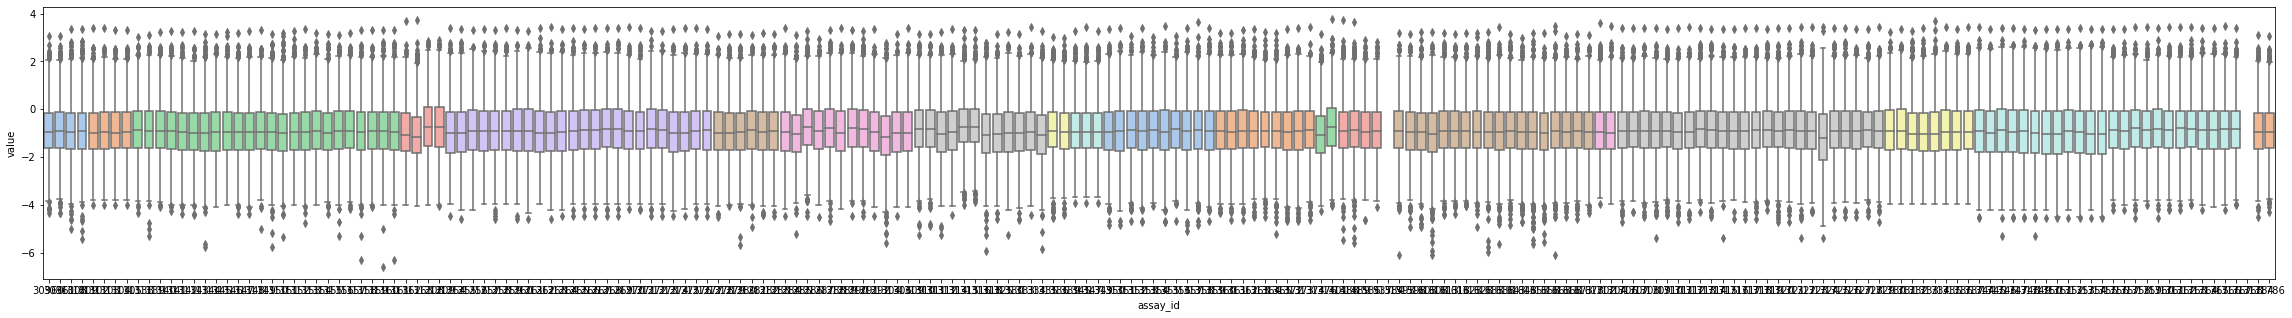

In [73]:
mapper = zip(meta.PXD_accession[:200].unique(), sns.color_palette("pastel", n_colors=meta.PXD_accession[:200].nunique()))
mapper = dict(mapper)
plt.figure(figsize=(40,5))
sns.boxplot(data=df_corrected_combat.melt()[df_corrected_combat.melt().assay_id.isin(df_corrected_combat.melt().assay_id.unique()[:200])], y="value", x = "assay_id", palette=meta.iloc[:200,:].PXD_accession.apply(lambda x: mapper[x]).values)

In [74]:
df_corrected_combat.melt()

,assay_id,value
0,30960,0.386686
1,30960,-0.138304
2,30960,-1.971517
3,30960,-2.139535
4,30960,-2.071382
...,...,...
1354565,36578,-2.005316
1354566,36578,-1.454681
1354567,36578,-1.452188
1354568,36578,-2.754154


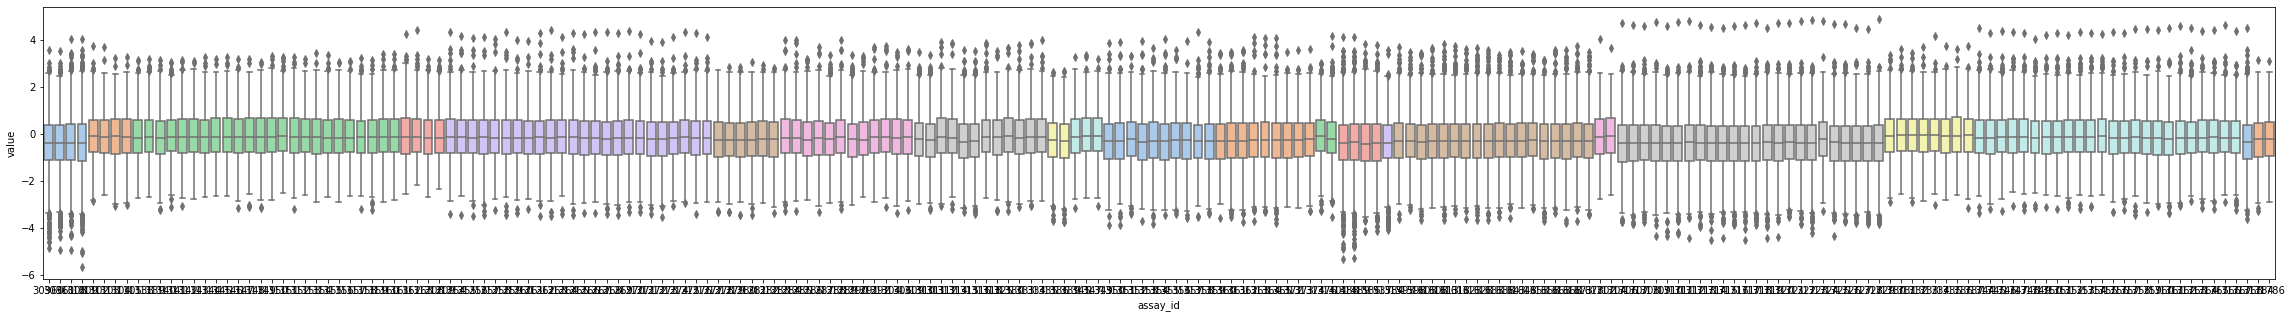

In [8]:
mapper = zip(meta.PXD_accession[:200].unique(), sns.color_palette("pastel", n_colors=meta.PXD_accession[:200].nunique()))
mapper = dict(mapper)
plt.figure(figsize=(40,5))
sns.boxplot(data=prep_data.T.melt()[prep_data.T.melt().assay_id.isin(prep_data.T.melt().assay_id.unique()[:200])], y="value", x = "assay_id", palette=meta.iloc[:200,:].PXD_accession.apply(lambda x: mapper[x]).values)

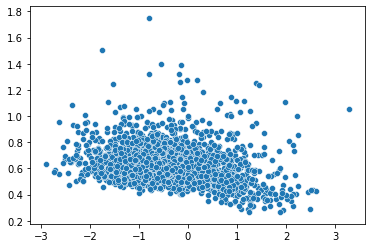

In [40]:
sns.scatterplot(x=prep_data.mean(skipna=True), y=prep_data.std(skipna=True))

In [44]:
prep_data.columns[prep_data.std(skipna=True)<.3]

Index(['P13010', 'P13639', 'P42704', 'P49411', 'P50991', 'P54136', 'Q7KZF4'], dtype='object')

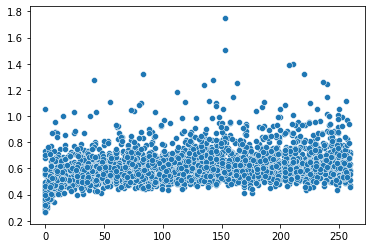

In [42]:
sns.scatterplot(x=prep_data.isna().sum(), y=prep_data.std(skipna=True))

In [15]:
import mysql.connector

conn = mysql.connector.connect(user='root', password='password', host='127.0.0.1', port='3306',database='expression_atlas_cells')
mycursor = conn.cursor(buffered = True)

# check the connection
if conn.is_connected():
    print("connection succesfull")
else:
    print("no connection")

seqsql = "SELECT protein.uniprot_id, protein.description FROM protein WHERE length IS NOT NULL"
uniprot_description = pd.read_sql_query(seqsql, conn)
uniprot_description.description = uniprot_description.description.apply(lambda x: x.split("(")[0])
uniprot_description = uniprot_description.set_index("uniprot_id")

connection succesfull


In [116]:
exp_data = np.exp2(prep_data).fillna(0)

In [118]:
meta.Group

assay_id
30960              HCC
30961              HCC
31008              HCC
31009              HCC
31102    Neuroblastoma
             ...      
36558    Ductal_breast
36563    Ductal_breast
36568    Ductal_breast
36573    Ductal_breast
36578    Ductal_breast
Name: Group, Length: 518, dtype: object

In [151]:
exp_per_group = pd.merge(exp_data.reset_index(), meta.Group.reset_index()).set_index("assay_id").groupby("Group").median().T

In [138]:
def calc_tau_exp(values, prot):
    max_val = max(values)

    tau = 0
    for i, v in enumerate(values):
        
        tau += (1-(v/max_val))

    val = np.round(tau/i, 2)
    if val > 1:
        return 0
    return val

In [152]:
tau_exp_data = {}
for prot_id, row in exp_per_group.iterrows():
    tau_exp_data[prot_id] = calc_tau_exp(row.tolist(), prot_id)

In [160]:
thpa_tissue = pd.read_csv('THPA_tissue.csv', index_col='Entry')

not_matched = []
matched= []
for prot in prep_data.columns:
    if prot not in thpa_tissue.index:
        not_matched.append(prot)
    else:
        matched.append(prot)
uniprot_description.loc[not_matched]

thpa_tissue = thpa_tissue.loc[matched]

tau_scores = {}
for prot_id, row in thpa_tissue.iterrows():
    
    tau_scores[prot_id] = calc_tau(row.tolist(), prot_id)

In [162]:
thpa_tissue

,adipose tissue,adrenal gland,amygdala,appendix,basal ganglia,bone marrow,breast,cerebellum,cerebral cortex,cervix,...,stomach,testis,thalamus,thymus,thyroid gland,tongue,tonsil,urinary bladder,vagina,white matter
Entry,,,,,,,,,,,,,,,,,,,,,
A0AVT1,6.7,6.6,5.9,9.9,8.0,17.1,8.3,7.5,7.5,10.6,...,9.4,10.0,8.7,10.4,7.9,6.5,13.6,10.2,10.6,16.0
A0MZ66,1.9,4.0,63.2,4.5,94.5,0.7,4.9,42.7,54.1,2.9,...,5.7,6.4,79.5,2.7,7.5,0.8,2.3,2.1,2.1,128.1
A0PJW6,13.1,20.9,10.4,9.4,12.0,6.4,12.8,12.4,13.4,13.2,...,15.4,6.7,10.4,7.3,13.8,8.5,7.0,12.2,11.1,12.1
A1X283,22.6,25.4,9.2,11.2,12.8,0.1,19.0,12.9,11.5,36.4,...,13.1,6.3,13.7,4.2,8.0,3.4,3.4,18.3,18.1,15.4
A2RRP1,16.8,21.0,37.4,7.2,38.8,16.1,15.9,37.7,42.7,18.8,...,24.5,41.2,37.2,14.5,17.4,17.7,9.1,19.7,16.5,38.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9Y6W3,13.9,11.9,4.6,11.6,5.9,13.2,16.6,12.5,5.4,16.9,...,14.0,12.1,6.8,16.9,23.5,16.5,15.7,10.2,9.8,9.7
Q9Y6W5,55.2,34.1,37.9,44.1,48.1,59.8,45.8,42.3,36.3,41.3,...,40.3,36.8,48.4,54.6,35.5,27.8,52.3,47.8,39.9,50.6
Q9Y6X9,15.6,14.4,6.6,7.0,6.7,6.6,16.6,8.5,8.3,20.6,...,16.2,45.2,7.0,8.0,15.6,10.2,7.3,21.2,18.5,7.3


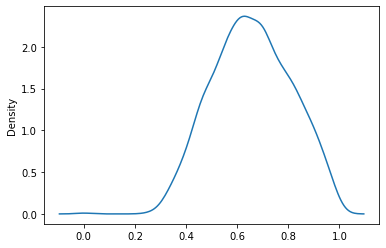

In [164]:
sns.kdeplot(list(tau_scores.values()))

In [50]:
thpa_cancer = pd.read_csv('THPA_nTPM_cancer.csv', index_col='Entry')

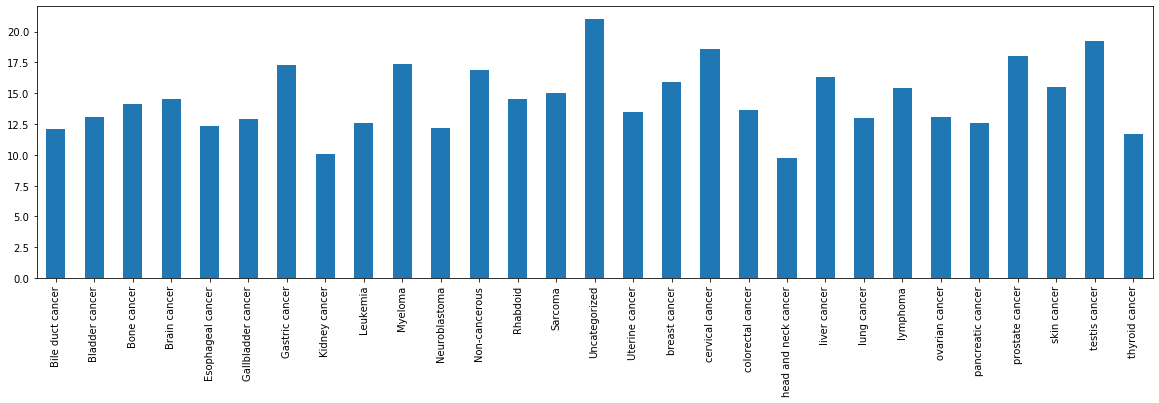

In [111]:
thpa_cancer.loc['Q9Y6W3'].plot(kind="bar",figsize=(20,5))

In [56]:
not_matched = []
matched= []
for prot in prep_data.columns:
    if prot not in thpa_cancer.index:
        not_matched.append(prot)
    else:
        matched.append(prot)
uniprot_description.loc[not_matched]

,description
uniprot_id,
L0R8F8,MIEF1 upstream open reading frame protein
P04179,"Superoxide dismutase [Mn], mitochondrial"
Q14568,Heat shock protein HSP 90-alpha A2
Q58FF6,Putative heat shock protein HSP 90-beta 4
Q58FF7,Putative heat shock protein HSP 90-beta-3
Q58FF8,Putative heat shock protein HSP 90-beta 2
Q58FG1,Putative heat shock protein HSP 90-alpha A4
Q5JSZ5,Protein PRRC2B
Q9BZK3,Putative nascent polypeptide-associated comple...


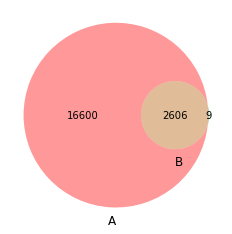

In [54]:
venn2((set(thpa_cancer.index), set(prep_data.columns)))

In [58]:
thpa_cancer = thpa_cancer.loc[matched]

In [93]:
def calc_tau(values, prot):
    max_val = max(values)

    tau = 0
    for i, v in enumerate(values):
        if v<1:
            tau += 1
        else:
            tau += (1-(v/max_val))

    val = np.round(tau/i, 2)
    if val > 1:
        return 0
    return val

In [182]:
tau_scores = {}
for prot_id, row in thpa_cancer.iterrows():
    
    tau_scores[prot_id] = calc_tau(row.tolist(), prot_id)

In [165]:
std_tau_comp = pd.concat([prep_data.std(skipna=True), pd.Series(tau_scores)],axis=1).rename(columns={0:'std', 1:'tau'})

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


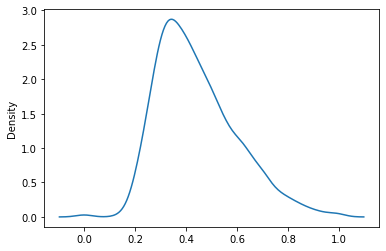

In [183]:
sns.kdeplot(list(tau_scores.values()))

In [99]:
std_tau_comp = pd.concat([prep_data.std(skipna=True), pd.Series(tau_scores)],axis=1).rename(columns={0:'std', 1:'tau'})

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [154]:
taus = pd.concat([pd.Series(data=tau_exp_data), pd.Series(data=tau_scores)],axis=1).rename(columns={0:'Tau_prot', 1:'Tau_THPA'})

/home/compomics/miniconda3/envs/ionbot/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


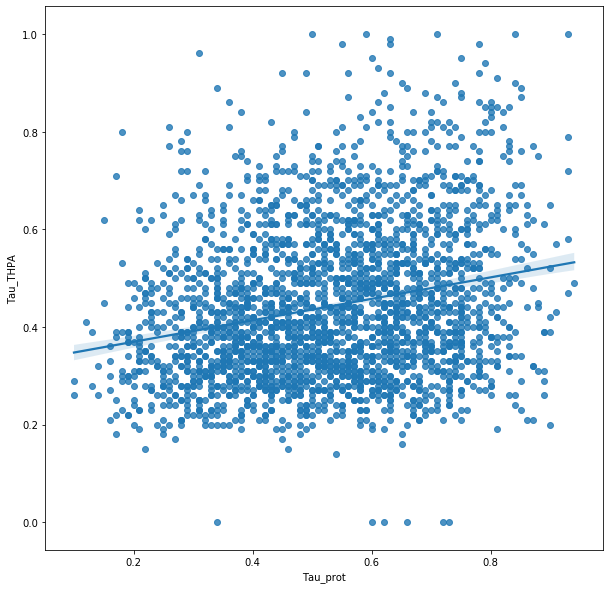

In [155]:
plt.figure(figsize=(10,10))
sns.regplot(data= taus , x="Tau_prot", y='Tau_THPA')

In [179]:
std_tau_comp['std'] = std_tau_comp['std'].apply(lambda x: np.log2(x))

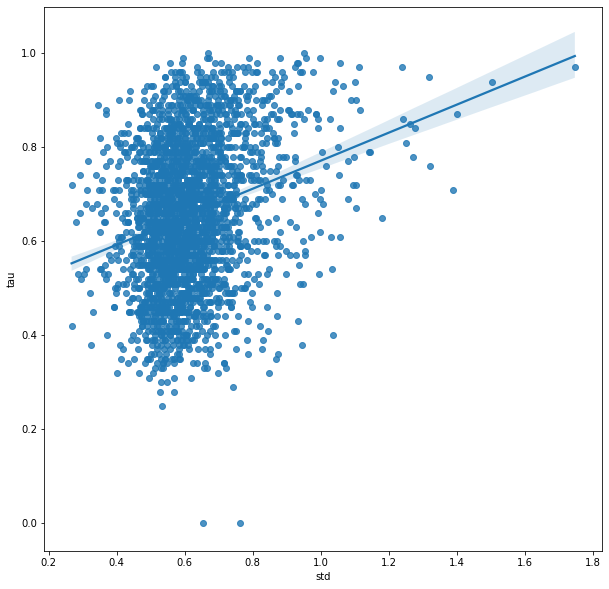

In [180]:
plt.figure(figsize=(10,10))
sns.regplot(data= std_tau_comp , x="std", y='tau')

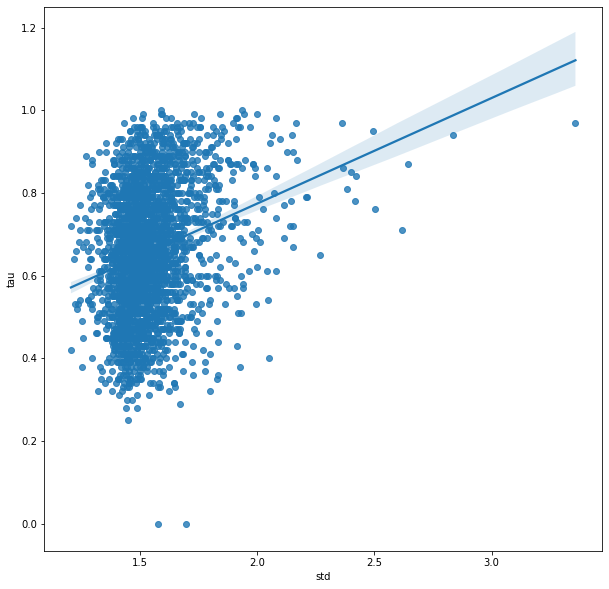

In [178]:
plt.figure(figsize=(10,10))
sns.regplot(data= std_tau_comp , x="std", y='tau')

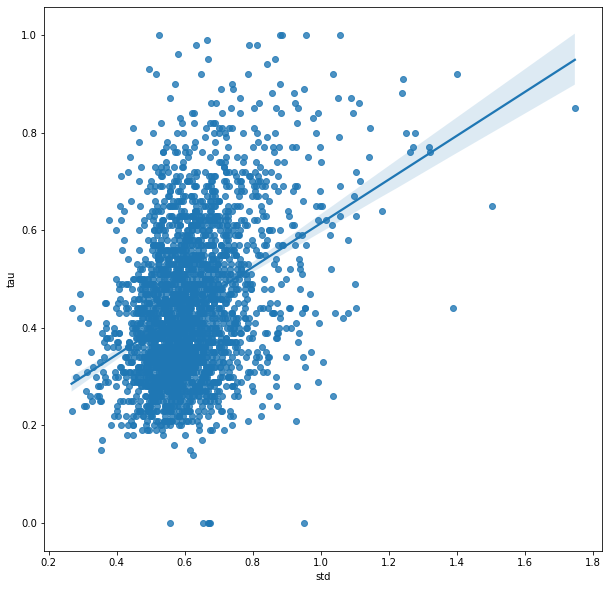

In [105]:
plt.figure(figsize=(10,10))
sns.regplot(data= std_tau_comp , x="std", y='tau')

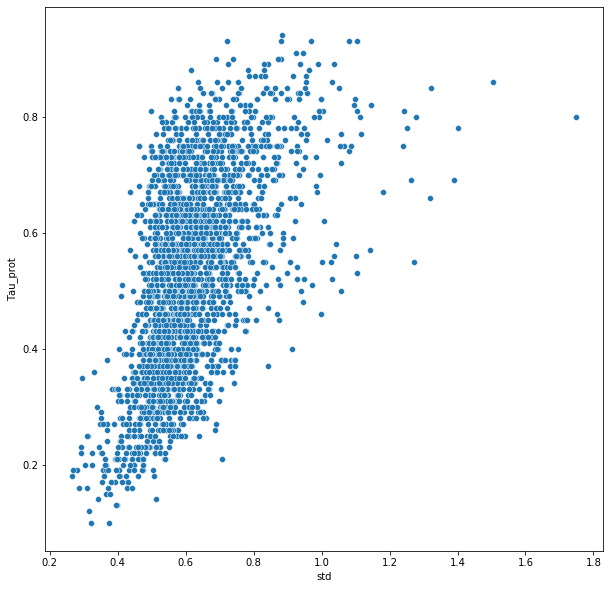

In [157]:
plt.figure(figsize=(10,10))
sns.scatterplot(x=std_tau_comp["std"], y=taus["Tau_prot"])

In [159]:
uniprot_description.loc[list(set(std_tau_comp[std_tau_comp['std']< .4].index).intersection(set(taus[taus["Tau_prot"]<.2].index)))]

,description
uniprot_id,
Q92900,Regulator of nonsense transcripts 1
P07900,Heat shock protein HSP 90-alpha
Q7KZF4,Staphylococcal nuclease domain-containing prot...
Q13200,26S proteasome non-ATPase regulatory subunit 2
P07954,"Fumarate hydratase, mitochondrial"
Q15046,Lysine--tRNA ligase
P53618,Coatomer subunit beta
P45974,Ubiquitin carboxyl-terminal hydrolase 5
O00232,26S proteasome non-ATPase regulatory subunit 12


In [46]:
uniprot_description.loc[prep_data.columns[prep_data.std(skipna=True)>1.3]]

,description
P15924,Desmoplakin
P16144,Integrin beta-4
P48681,Nestin
Q02952,A-kinase anchor protein 12
Q14315,Filamin-C
Q8IVF2,Protein AHNAK2
